In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics as metrics

In [2]:
df = pd.read_csv('anon_data.csv')

In [3]:
# df.head()

In [4]:
df.columns

Index(['first_course_year', 'semester_idx', 'female', 'white_asian',
       'start_age', 'first_gen', 'HS_Zip_Code', 'changed_major', 'n_majors',
       'total_semester_credit_hours', 'cumulative_credit_hours',
       'graduated_semester_idx', 'graduates_next_semester', 'graduated',
       'AP_credit_hours', 'major_credits', 'nonmajor_credits', 'major_gpa',
       'nonmajor_gpa', 'enrolled_in_previous_semester', 'avg_grade',
       'cumulative_avg_grade', 'fraction_above_or_below_fulltime_credithours',
       'hs_gpa', 'math_placement_score', 'train', 'Id', 'Id2', 'Geography',
       'Median income (dollars); Estimate; Households',
       'Median income (dollars); Margin of Error; Households',
       'Number; Estimate; FAMILIES - Families',
       'Number; Margin of Error; FAMILIES - Families',
       'Median income (dollars); Estimate; FAMILIES - Families',
       'Median income (dollars); Margin of Error; FAMILIES - Families',
       'zipstr', 'zip_median_income_log', 'anon_id'],
   

In [5]:
firstfour = df[df.semester_idx.isin([1,2,3,4])]

In [6]:
firstfour.anon_id.unique().shape

(188685,)

In [7]:
columns_to_pivot = ['changed_major', 'n_majors',
       'total_semester_credit_hours', 'cumulative_credit_hours', 'major_credits', 'nonmajor_credits', 'major_gpa', 'nonmajor_gpa', 'enrolled_in_previous_semester', 'avg_grade', 'hs_gpa', 'cumulative_avg_grade', 'math_placement_score', 'fraction_above_or_below_fulltime_credithours',]

In [8]:
pivoted = pd.DataFrame()
for c in columns_to_pivot:
    pvt = firstfour.pivot_table(index='anon_id', columns='semester_idx', values=c)
    if c in ['hs_gpa', 'math_placement_score']:
        # in this case, we remove all the subsequent hs_gpa and 
        # math_placement_score because they are calculated with
        # respect to students in the adjoining semester_idx
        # therefore only the first semester is relevant since it
        # is the incoming class. Technically these should be
        # static columns.
        pvt = pvt[[pvt.columns[0]]]
        pvt.columns = [c + str(int(i)) for i in pvt.columns]

    else:
        pvt.columns = [c + str(int(i)) for i in pvt.columns]
    pivoted = pd.concat([pivoted, pvt], axis=1, sort=False)

In [9]:
static_columns = ['first_course_year', 'female', 'white_asian',
       'start_age', 'first_gen', 'HS_Zip_Code', 'graduated', 'AP_credit_hours',
       'Median income (dollars); Estimate; FAMILIES - Families', 'zip_median_income_log', 'anon_id']

In [10]:
ff = firstfour[static_columns].drop_duplicates().set_index('anon_id')

In [11]:
data = pd.concat([pivoted, ff], axis=1, sort=False)

In [12]:
data.head()

,changed_major1,changed_major2,changed_major3,changed_major4,n_majors1,n_majors2,n_majors3,n_majors4,total_semester_credit_hours1,total_semester_credit_hours2,...,first_course_year,female,white_asian,start_age,first_gen,HS_Zip_Code,graduated,AP_credit_hours,Median income (dollars); Estimate; FAMILIES - Families,zip_median_income_log
anon_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,12.0,NaN,...,10.0,0.0,0.0,73.0,0.0,NaN,1.0,0.0,NaN,NaN
1,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,NaN,...,0.0,1.0,0.0,56.0,0.0,NaN,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,12.0,12.0,...,1.0,0.0,1.0,59.0,0.0,NaN,1.0,0.0,NaN,NaN
3,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,NaN,...,10.0,1.0,0.0,61.0,0.0,NaN,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,11.0,5.0,...,7.0,0.0,0.0,63.0,0.0,NaN,1.0,0.0,NaN,NaN


In [13]:
z = data.corr()

In [14]:
z[(z.abs() > 0.3) & (z.abs()<1)].dropna(axis=1, how='all')

,n_majors1,n_majors2,n_majors3,n_majors4,total_semester_credit_hours1,total_semester_credit_hours2,total_semester_credit_hours3,total_semester_credit_hours4,cumulative_credit_hours1,cumulative_credit_hours2,...,fraction_above_or_below_fulltime_credithours3,fraction_above_or_below_fulltime_credithours4,first_course_year,white_asian,start_age,first_gen,graduated,AP_credit_hours,Median income (dollars); Estimate; FAMILIES - Families,zip_median_income_log
changed_major1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
changed_major2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
changed_major3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
changed_major4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_majors1,NaN,0.860049,0.806881,0.767976,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_majors2,0.860049,NaN,0.921842,0.869574,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300972,NaN,NaN
n_majors3,0.806881,0.921842,NaN,0.904908,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.318801,NaN,NaN
n_majors4,0.767976,0.869574,0.904908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321543,NaN,NaN
total_semester_credit_hours1,NaN,NaN,NaN,NaN,NaN,0.341015,NaN,0.307839,NaN,0.795401,...,NaN,0.306205,NaN,NaN,-0.326563,NaN,NaN,NaN,NaN,NaN
total_semester_credit_hours2,NaN,NaN,NaN,NaN,0.341015,NaN,NaN,NaN,0.341015,0.840997,...,NaN,NaN,NaN,NaN,-0.304019,NaN,NaN,NaN,NaN,NaN


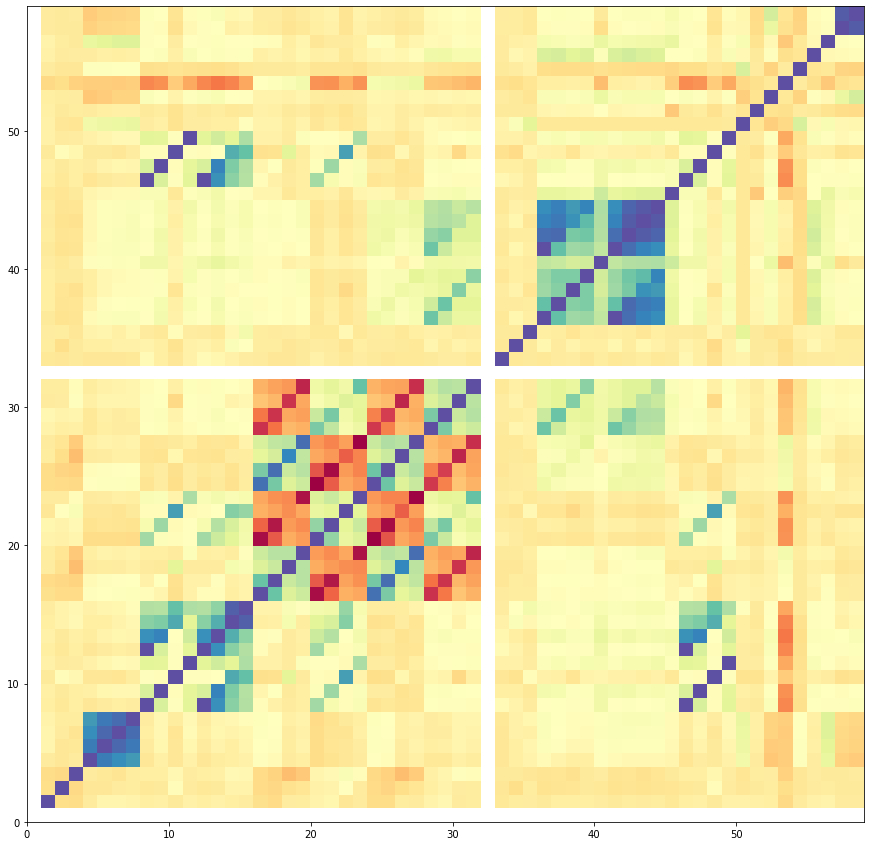

In [15]:
# xticks = data.columns
# yticks = data.index

fig, ax = plt.subplots(figsize=(15, 15))

ax.pcolormesh(z, cmap='Spectral')
# ax.set_xticks(np.arange(1.5, xticks.shape[0]-0.5, 1))
# ax.set_yticks(np.arange(1.5, yticks.shape[0]-0.5, 1))

# ax.set_xticklabels(xticks)
# ax.set_yticklabels(yticks)

In [16]:
data.columns

Index(['changed_major1', 'changed_major2', 'changed_major3', 'changed_major4',
       'n_majors1', 'n_majors2', 'n_majors3', 'n_majors4',
       'total_semester_credit_hours1', 'total_semester_credit_hours2',
       'total_semester_credit_hours3', 'total_semester_credit_hours4',
       'cumulative_credit_hours1', 'cumulative_credit_hours2',
       'cumulative_credit_hours3', 'cumulative_credit_hours4',
       'major_credits1', 'major_credits2', 'major_credits3', 'major_credits4',
       'nonmajor_credits1', 'nonmajor_credits2', 'nonmajor_credits3',
       'nonmajor_credits4', 'major_gpa1', 'major_gpa2', 'major_gpa3',
       'major_gpa4', 'nonmajor_gpa1', 'nonmajor_gpa2', 'nonmajor_gpa3',
       'nonmajor_gpa4', 'enrolled_in_previous_semester1',
       'enrolled_in_previous_semester2', 'enrolled_in_previous_semester3',
       'enrolled_in_previous_semester4', 'avg_grade1', 'avg_grade2',
       'avg_grade3', 'avg_grade4', 'hs_gpa1', 'cumulative_avg_grade1',
       'cumulative_avg_grade2'

In [17]:
data = data[['changed_major1', 'changed_major2', 'changed_major3', 'changed_major4',
       'n_majors1', 'n_majors2', 'n_majors3', 'n_majors4',
       'total_semester_credit_hours1', 'total_semester_credit_hours2',
       'total_semester_credit_hours3', 'total_semester_credit_hours4',
       'cumulative_credit_hours1', 'cumulative_credit_hours2',
       'cumulative_credit_hours3', 'cumulative_credit_hours4',
       'major_credits1', 'major_credits2', 'major_credits3', 'major_credits4',
       'nonmajor_credits1', 'nonmajor_credits2', 'nonmajor_credits3',
       'nonmajor_credits4', 'major_gpa1', 'major_gpa2', 'major_gpa3',
       'major_gpa4', 'nonmajor_gpa1', 'nonmajor_gpa2', 'nonmajor_gpa3',
       'nonmajor_gpa4', 'enrolled_in_previous_semester1',
       'enrolled_in_previous_semester2', 'enrolled_in_previous_semester3',
       'enrolled_in_previous_semester4', 'avg_grade1', 'avg_grade2',
       'avg_grade3', 'avg_grade4', 'hs_gpa1', 'cumulative_avg_grade1',
       'cumulative_avg_grade2', 'cumulative_avg_grade3',
       'cumulative_avg_grade4', 'math_placement_score1',
       'fraction_above_or_below_fulltime_credithours1',
       'fraction_above_or_below_fulltime_credithours2',
       'fraction_above_or_below_fulltime_credithours3',
       'fraction_above_or_below_fulltime_credithours4', 'first_course_year',
       'female', 'white_asian', 'start_age', 'first_gen', 'AP_credit_hours',
       'zip_median_income_log', 'graduated']]

# data['hs_gpa1'] = data['hs_gpa1'].astype(np.float64)

In [18]:
data.dtypes

changed_major1                                   float64
changed_major2                                   float64
changed_major3                                   float64
changed_major4                                   float64
n_majors1                                        float64
n_majors2                                        float64
n_majors3                                        float64
n_majors4                                        float64
total_semester_credit_hours1                     float64
total_semester_credit_hours2                     float64
total_semester_credit_hours3                     float64
total_semester_credit_hours4                     float64
cumulative_credit_hours1                         float64
cumulative_credit_hours2                         float64
cumulative_credit_hours3                         float64
cumulative_credit_hours4                         float64
major_credits1                                   float64
major_credits2                 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], random_state=42)

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 2, 'eta': 0.3, 'objective': 'reg:logistic'}
bst = xgb.train(param, dtrain, num_boost_round=20000)

preds = bst.predict(dtest)

Text(0.6, 0.0, 'AUC = 0.86')

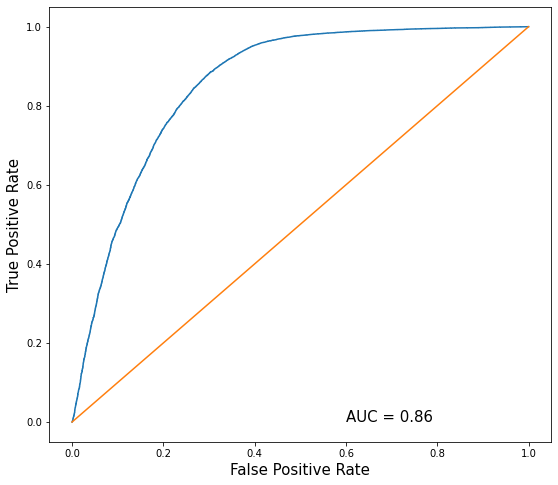

In [21]:
fpr, tpr, t = metrics.roc_curve(y_true=y_test, y_score=preds)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1])

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=y_test, y_score=preds),2))
    , x=0.6, y=0.0, fontsize=15
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

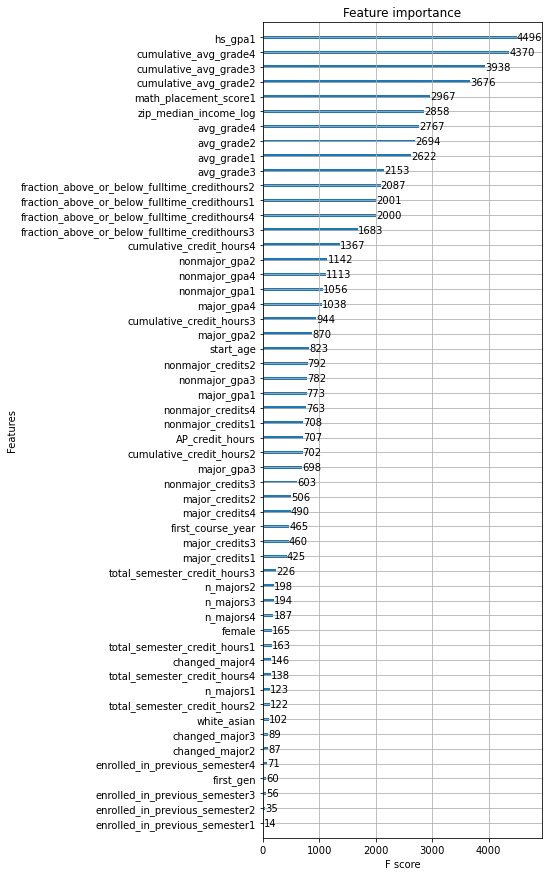

In [22]:
fig, ax = plt.subplots(figsize=(5, 15))
xgb.plot_importance(bst, ax=ax)

In [23]:
def detect_dropout(data):
#     if data.changed_major2 + data.changed_major3 + data.changed_major4 == np.nan:
    if np.isnan(data.changed_major2) and np.isnan(data.changed_major3) and np.isnan(data.changed_major4) == True:
        return 2
    else:
        return 0

data.apply(lambda x: detect_dropout(x), axis=1).max()

2

In [24]:
data['multiclass'] = (data['graduated'] + data.apply(lambda x: detect_dropout(x), axis=1))

In [25]:
print(data['multiclass'].unique())
"""
3 : left and came back to graduate
2 : left
1 : graduated
0 : left after 4 semesters
"""

[3. 2. 1. 0.]


'\n3 : left and came back to graduate\n2 : left\n1 : graduated\n0 : left after 4 semesters\n'

In [26]:
data.columns

Index(['changed_major1', 'changed_major2', 'changed_major3', 'changed_major4',
       'n_majors1', 'n_majors2', 'n_majors3', 'n_majors4',
       'total_semester_credit_hours1', 'total_semester_credit_hours2',
       'total_semester_credit_hours3', 'total_semester_credit_hours4',
       'cumulative_credit_hours1', 'cumulative_credit_hours2',
       'cumulative_credit_hours3', 'cumulative_credit_hours4',
       'major_credits1', 'major_credits2', 'major_credits3', 'major_credits4',
       'nonmajor_credits1', 'nonmajor_credits2', 'nonmajor_credits3',
       'nonmajor_credits4', 'major_gpa1', 'major_gpa2', 'major_gpa3',
       'major_gpa4', 'nonmajor_gpa1', 'nonmajor_gpa2', 'nonmajor_gpa3',
       'nonmajor_gpa4', 'enrolled_in_previous_semester1',
       'enrolled_in_previous_semester2', 'enrolled_in_previous_semester3',
       'enrolled_in_previous_semester4', 'avg_grade1', 'avg_grade2',
       'avg_grade3', 'avg_grade4', 'hs_gpa1', 'cumulative_avg_grade1',
       'cumulative_avg_grade2'

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-2]], data[data.columns[-1]], random_state=42)

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 2, 'eta': 0.3, 'objective': 'multi:softmax', 'num_class':4}
model = xgb.XGBClassifier(param, num_boost_round=20000)
# bst = xgb.train(param, dtrain, num_boost_round=20000)
bst = model.fit(X_train, y_train)

# preds = bst.predict(dtest)

[14:57:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [29]:
predictions = bst.predict_proba(X_test)

In [30]:
data['multiclass'].unique()

array([3., 2., 1., 0.])

In [31]:
from sklearn.preprocessing import label_binarize
y = label_binarize(y_test, classes=[0, 1, 2, 3])

In [32]:
predictions[:,2]

array([3.8086330e-06, 2.3251094e-05, 8.8056316e-07, ..., 1.2839233e-06,
       9.2181466e-07, 3.2059206e-06], dtype=float32)

In [33]:
fpr[1] = [1,2, 3]
fpr
predictions[:, 1]

ValueError: setting an array element with a sequence.

In [ ]:
metrics.roc_curve(y_true=y[:, i], y_score=predictions[:, i])

In [ ]:
metrics.roc_curve(y_true=[1,0,1,1,1,0], y_score=[0.9,0.8,0.2,0.1,0.85,0.25])

In [ ]:
y[:, i]

In [ ]:
i

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# for i in range(n_classes):
for i in data['multiclass'].unique().astype(int):
#     fpr[i], tpr[i], t = metrics.roc_curve(y_test[:, i], predictions[:, i])
    fpr[i], tpr[i], t = metrics.roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])/4
# for i in data['multiclass'].unique().astype(int):

ax.plot(all_fpr, mean_tpr)
for i, n in zip(range(4), y.sum(axis=0)):
    ax.plot(fpr[i], tpr[i], label='class={i} nTrue={n}'.format(i=i, n=n))
    
ax.legend(fontsize=15)
"""
3 : left and came back to graduate
2 : left
1 : graduated
0 : left after 4 semesters
"""

In [ ]:
y.sum(axis=0)

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))


In [ ]:
np.linspace(0, 1, 101)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))

for i in data['multiclass'].unique():
    index = y_test[y_test==i].index
    fpr, tpr, t = metrics.roc_curve(y_true=y_test.loc[index]-i, y_score=predictions.loc[index]-i)
    print(t)


    ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1])

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)

In [ ]:
from sklearn import datasets, svm
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

In [ ]:
y_te

In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_tr, y_tr).decision_function(X_te)


In [ ]:
y_score